This test notebook explores the use of Conguate gradients to perform the solve

In [1]:
import numpy as np
import tensorflow as tf
import tenfem
import matplotlib.pyplot as plt
from tenfem.layers import (AssembleStiffnessMatrix,
                           AssembleLoadVector, )
from tenfem.fem import dirichlet_form_linear_system

from tensorflow.linalg.experimental import conjugate_gradient

tf_dtype = tf.float32

In [31]:
# create our mesh
mesh = tenfem.mesh.examples.square(16, 16, dtype=tf_dtype)
mesh = tenfem.mesh.triangle.convert_linear_to_quadratic(mesh)
element = tenfem.reference_elements.TriangleElement(degree=2, dtype=tf_dtype)

In [32]:
diffusion_coefficient = lambda x: tf.ones_like(x[..., 0])

mesh_tensor_repr = mesh.get_tensor_repr()
stiffness_matrix = AssembleStiffnessMatrix(diffusion_coefficient,
                                           reference_element=element)(mesh_tensor_repr)

load_vector = AssembleLoadVector(lambda x: tf.ones_like(x)[..., 0],
                                 reference_element=element)(mesh_tensor_repr)

In [33]:
A = stiffness_matrix[0]
b = load_vector[0]

In [34]:
A.shape, b.shape

(TensorShape([961, 961]), TensorShape([961, 1]))

In [35]:
_, _, _, node_types = mesh.get_tensor_repr()
ao, bo = dirichlet_form_linear_system(A, b, node_types)

In [36]:
ao.shape, bo.shape

(TensorShape([841, 841]), TensorShape([841, 1]))

In [37]:
def solve_lu(A, b):
    lu, p = tf.linalg.lu(A)
    return tf.linalg.lu_solve(lu, p, b)

def solve_cg(A, b):
    A = tf.linalg.LinearOperatorFullMatrix(
        A, is_self_adjoint=True, is_positive_definite=True)
    return conjugate_gradient(A, b, tol=1e-5, max_iter=50)

import time
t0 = time.time()
u1 = solve_lu(ao, bo)
t1 = time.time()
print(t1-t0)

t0 = time.time()
u2 = solve_cg(ao, bo[..., 0])
t1 = time.time()
print(t1 - t0)

0.06401896476745605
0.06029391288757324


In [29]:
np.max(np.abs(u1[..., 0] - u2.x))

0.0007326603

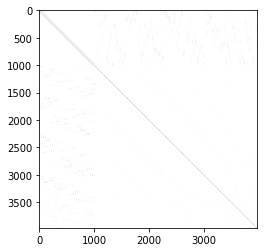

In [30]:
A = stiffness_matrix[0].numpy()
mask = (np.abs(A) < 1e-8).astype(np.intp)

plt.imshow(mask, cmap=plt.cm.gray)

In [11]:
1 - np.sum(mask) / A.size

0.011370613120871065

In [12]:
b = tf.random.normal(shape=[mesh.n_nodes, 1])

In [13]:
import time
t0 = time.time()
res = tf.matmul(A, b)
t1 = time.time()
print(t1 - t0)

0.0007638931274414062


In [14]:
import time
t0 = time.time()
res = tf.linalg.matmul(A, b, a_is_sparse=True)
t1 = time.time()
print(t1 - t0)

Instructions for updating:
Use `tf.linalg.matmul` instead
0.0020868778228759766


In [15]:
element_dim = element.element_dim
mesh_quadrature_nodes = element.get_quadrature_nodes(mesh)
# mesh_quadrature_nodes.shape # [n_elements, element_dim, spatial_dim]
spatial_dim = tf.shape(mesh_quadrature_nodes)[-1]
flat_mesh_quadrature_nodes = tf.reshape(mesh_quadrature_nodes, [-1, 2])

diffusion_coeff_vals = tf.reshape(
    diffusion_coefficient(flat_mesh_quadrature_nodes),
    [-1, mesh.n_elements, element_dim])


local_stiffness_mat = tenfem.fem.assemble_local_stiffness_matrix(
    diffusion_coeff_vals, mesh, element)

In [16]:
local_stiffness_mat.shape # [1, n_elements, 6, 6]

TensorShape([1, 450, 6, 6])

In [17]:
a_local = local_stiffness_mat.shape[0]

In [18]:
inds = tenfem.fem.indexing_utils.get_batched_element_indices(
    mesh.elements[tf.newaxis, ...])

In [19]:
mesh.elements.shape

TensorShape([450, 6])

In [20]:
inds

<tf.Tensor: shape=(16200, 3), dtype=int32, numpy=
array([[  0,   1,   1],
       [  0,   1,  16],
       [  0,   1,   0],
       ...,
       [  0, 954, 960],
       [  0, 954, 930],
       [  0, 954, 954]], dtype=int32)>